<a href="https://colab.research.google.com/github/swecomic/xray/blob/master/dataloader_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

loading annotations into memory...
Done (t=10.53s)
creating index...
index created!


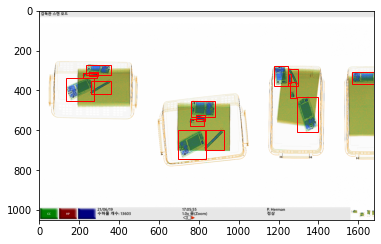

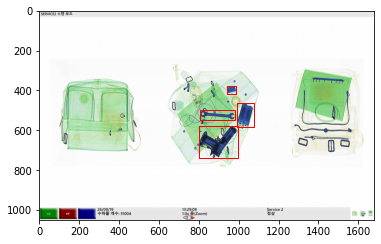

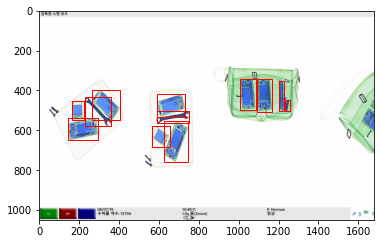

In [13]:
import os
import random
import torch
import torch.utils.data
import torchvision
import cv2
import numpy as np
from PIL import Image
from matplotlib import transforms
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor



### path to your own data and coco file ###

# A. Ububtu Path
# train_data_dir = '/data/jiylee/dataset/xray/Train/Data'
# train_coco = '/data/jiylee/dataset/xray/Train/Meta/CoCo/coco_rapiscan.json'

# B. Colab Path
train_data_dir = '/content/drive/' + 'Shared drives' + '/YS_NW/2.Data/Train/Data'
train_coco = '/content/drive/Shared drives/YS_NW/2.Data/Train/Meta/CoCo/coco_rapiscan.json'


class xrayDataset(torch.utils.data.Dataset):

    def __init__(self, root, annotation, class_nm=None, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.class_nm = class_nm

        # All images or a subs)et?
        if self.class_nm:
            class_id = sorted(self.coco.getCatIds(catNms=self.class_nm))
            self.ids = []

            for id in class_id:
                temp_id = self.coco.getImgIds(catIds=[id])
                # 공유폴더에 이미지가 존재하는것만 index를 만들어줌
                for i in temp_id:
                    fname = self.coco.imgs[i]['path'].split('\\', maxsplit=7)[-1].replace('\\', '/')

                    if os.path.isfile(os.path.join(self.root, fname)):
                        self.ids.append(i)
            # Remove duplicates
            self.ids = list(set(self.ids))
        else:
            # All images
            self.ids = list(sorted(self.coco.imgs.keys()))

        # All images or a subs)et?
        # if self.class_nm:
        #     class_id = sorted(self.coco.getCatIds(catNms=self.class_nm))
        #     self.ids = []
        #     for id in class_id:
        #         self.ids.extend(list(self.coco.getImgIds(catIds=[id])))
        #     # Remove duplicates
        #     self.ids = list(set(self.ids))
        # else:
        #     # All images
        #     self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco

        # Image ID
        img_id = self.ids[index]

        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)

        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)

        # Load Image
        img_info = coco.loadImgs(coco_annotation[0]["image_id"])

        # file path
        file_path = img_info[0]["path"].split('\\', maxsplit=7)[-1]

        # open the input image
        image_path = os.path.join(self.root, file_path.replace('\\', '/'))
        img = Image.open(image_path)

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        class_id = []
        for i in range(num_objs):
            # bbox
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

            # class_id
            cid = coco_annotation[i]["category_id"]
            class_id.append(cid)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        class_id = torch.as_tensor(class_id)

        image_id = coco_annotation[0]["image_id"]
        file_name = img_info[0]["file_name"]

        # Tensorise
        image_id = torch.tensor([image_id])
        # file_name = torch.tensor([file_name])

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["class_id"] = class_id
        my_annotation["image_id"] = image_id
        # my_annotation["file_name"] = file_name

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)


# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


# just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())

    return torchvision.transforms.Compose(custom_transforms)

# show image
def show_image(sample_img, sample_anno):
    plt.imshow(sample_img)

    # bbox
    bb = np.array(sample_anno["boxes"], dtype=np.float32)
    for j in range(len(bb)):
        line = plt.Rectangle((bb[j][0], bb[j][1]), bb[j][2] - bb[j][0], bb[j][3] - bb[j][1], color="red", fill=False,
                             lw=1)
        plt.gca().add_patch(line)

    return plt


# create own Dataset
class_nm = ['Battery']
my_dataset = xrayDataset(root=train_data_dir,
                         annotation=train_coco,
                         class_nm=class_nm,
                         transforms=get_transform()
                         )

# Batch size
train_batch_size = 32

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    # print(annotations)


# show random 3 images
random_sample = random.sample(range(0, len(my_dataset)-1), 3)
for i in random_sample:

    sample_img = np.array(my_dataset[i][0].permute(1, 2, 0), dtype=np.float32)
    sample_anno = my_dataset[i][1]

    show_image(sample_img, sample_anno)
    plt.show()

    if i ==3:
        break
